<a href="https://colab.research.google.com/github/sajidmeo/Awesome-Hacking/blob/master/final_tune_nfr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial


In [0]:

#url="https://raw.githubusercontent.com/sajidmeo/Datasets/master/Fiverr_data.csv"
url="https://raw.githubusercontent.com/sajidmeo/Datasets/master/Fiverr_data1.csv"

df=pd.read_csv(url,names=["classified","query","nfr"] ,encoding='cp1252')

In [3]:
df

,classified,query,nfr
0,1,The system shall refresh the display every 60 ...,Performance
1,1,The application shall match the color of the s...,Look and feel
2,1,The product shall be available during normal ...,Availability
3,1,If projected the data must be understandable...,Usability
4,1,The product shall ensure that it can only be a...,Security
...,...,...,...
666,17,The system shall have the ability to add a new...,Flexibility
667,16,The elapsed duration of time required to produ...,Scalability
668,16,The business rules repository shall be scalabl...,Scalability
669,16,The payroll system shall be scalable to suppor...,Scalability


In [4]:
df.shape

(671, 3)

In [0]:
#df
df=pd.DataFrame({'label':df["nfr"], 'text':df["query"]})

In [6]:
df['label'].value_counts()

Functional Requirement    252
Security                   77
Usability                  74
Operational                60
Performance                53
Look and feel              37
Scalability                30
Availability               29
Maintainability            23
Legal                      12
Fault tolerance            10
Portability                 7
Flexibility                 7
Name: label, dtype: int64

In [0]:
# spliting data into train and test
from sklearn.model_selection import train_test_split
df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.25, random_state = 12)

In [8]:
df_trn.shape, df_val.shape

((503, 2), (168, 2))

In [9]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [10]:
data_lm.show_batch()

idx,text
0,be updated on a xxunk basis . xxmaj the product will have a new major feature introduced every six months and xxunk maintenance releases every six months . xxbos xxmaj the streaming server will support a maximum of xxunk movies ; new servers can be added to support more movies . xxbos a xxunk database will be used to store xxunk statistics and data . xxbos xxmaj the product shall
1,language when entering their personal information . xxbos xxmaj an xxunk survey will show that 95 % of customers are xxunk using and xxunk pre - paid cards after a month of using the system . xxbos xxmaj the interface shall be appealing to callers and supervisors . xxmaj in the interface and usability survey 80 % of beta testers must report
2,lab section xxunk to the same clinical class . xxbos a non - clinical class shall specify the course name lecture room requirements and instructor needs . xxbos xxmaj the process must fit within the processing time conditions set forth by the xxmaj xxunk xxmaj xxunk xxmaj assignment process in which a lead is assigned within 3 minutes of the total xxunk cycle . xxbos xxmaj the product shall adhere
3,able to use the product . xxbos xxmaj the xxmaj disputes xxmaj system will provide the user the ability to create or initiate a ticket retrieval request . xxmaj as part of ticket retrieval creation process the system must prompt the user to enter all the required information to create the ticket retrieval request . xxmaj the ticket retrieval request is a document
4,"is xxunk , the system shall xxunk a user with notification xxunk them that the system is unavailable . xxbos xxmaj the product must comply with xxmaj xxunk - xxmaj xxunk . xxbos xxmaj the system shall have high availability every day of the year . xxmaj the system must be available for"


In [11]:
data_lm.vocab.itos[:15]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 '\xa0',
 '.',
 'shall',
 'to',
 'of']

In [12]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
# Language model
#learner = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.5)

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


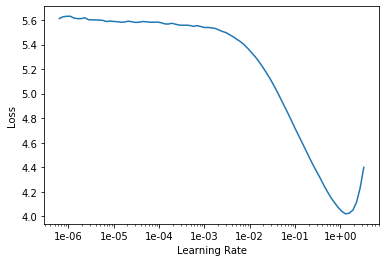

In [14]:
# loss vs learning rate
learn.recorder.plot()

In [15]:
# train the learner object with learning rate = 1e-01
learn.fit_one_cycle(15, 1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,5.287890,4.706004,0.283705,00:01
1,4.785061,3.756432,0.286607,00:01
2,4.214342,2.967497,0.379018,00:01
3,3.714859,2.998947,0.404911,00:01
4,3.303046,2.934620,0.434152,00:01
5,2.964940,2.977040,0.431250,00:01
6,2.682097,2.988847,0.453348,00:01
7,2.448636,3.058493,0.451116,00:01
8,2.252656,3.053391,0.457589,00:01
9,2.088221,3.072308,0.456250,00:01


In [16]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)




epoch,train_loss,valid_loss,accuracy,time
0,0.904118,3.146467,0.465179,00:01
1,0.887602,3.125211,0.467857,00:01
2,0.880277,3.170005,0.459598,00:01
3,0.835123,3.145588,0.475223,00:01
4,0.828838,3.218286,0.464732,00:01
5,0.784953,3.317379,0.460938,00:01
6,0.756307,3.210788,0.469866,00:01
7,0.722839,3.246891,0.465848,00:01
8,0.698242,3.260875,0.466518,00:01
9,0.677945,3.251563,0.468080,00:01


In [17]:
learn.predict("this is movie of",n_words=5)

'this is movie of the day due to 11:00'

In [0]:
learn.save_encoder('fine_enc')

In [19]:
# Classifier model data
data_clas = TextClasDataBunch.from_df('./', train_df=df_trn, valid_df=df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [20]:
# Classifier
classifier = text_classifier_learner(data_clas,AWD_LSTM, drop_mult=0.5)
classifier.load_encoder('fine_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (503 items)
x: TextList
xxbos xxmaj the product shall be able to delete room equipment .,xxbos xxmaj the product shall process messages within 2 seconds . xxmaj the product shall have a maximum xxunk processing time of 2 seconds,xxbos xxmaj the product shall be easy to learn by xxmaj adjusters and xxmaj collision xxmaj estimators . xxmaj the product shall be xxunk with two days xxunk training,xxbos xxmaj the product shall be updated on a xxunk basis . xxmaj the product will have a new major feature introduced every six months and xxunk maintenance releases every six months .,xxbos xxmaj the streaming server will support a maximum of xxunk movies ; new servers can be added to support more movies .
y: CategoryList
Functional Requirement,Performance,Usability,Maintainability,Scalability
Path: .;

Valid: LabelList (168 items)
x: TextList
xxbos xxmaj the   xxunk   system   shall   be   scalable   to   support   unlimited   xxunk   in   th

In [21]:
classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


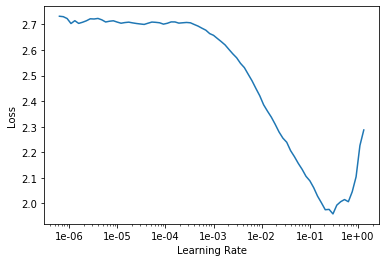

In [22]:
classifier.recorder.plot()

In [23]:
classifier.fit_one_cycle(10,1e-02,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.451294,2.230604,0.511905,00:01
1,1.968009,1.521669,0.601190,00:01
2,1.657631,1.254111,0.607143,00:01
3,1.417804,1.189118,0.625000,00:01
4,1.211949,1.224476,0.654762,00:01
5,1.039908,1.108947,0.666667,00:01
6,0.915105,1.164904,0.660714,00:01
7,0.821662,1.152744,0.672619,00:01
8,0.729330,1.130512,0.672619,00:01
9,0.665351,1.104214,0.672619,00:01


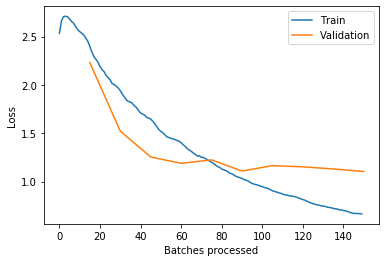

In [24]:
classifier.recorder.plot_losses()

Deep Learning Hyper-parameter Tuning Techniques

In [25]:
learn.lr_range(slice(1e-5,1e-3))

array([1.000000e-05, 4.641589e-05, 2.154435e-04, 1.000000e-03])

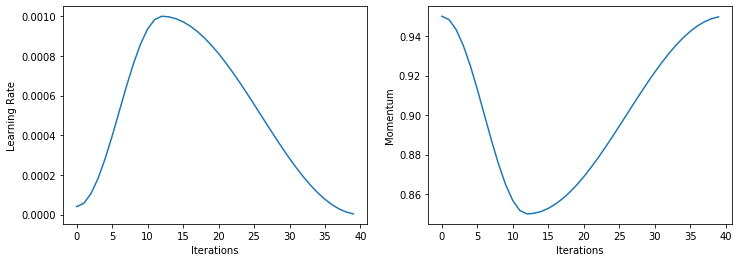

In [26]:
learn.recorder.plot_lr(show_moms=True)

In [27]:
classifier.freeze_to(-10)
classifier.fit_one_cycle(10,slice(5e-3/10.,5e-3),moms=(0.7,0.3))

epoch,train_loss,valid_loss,accuracy,time
0,0.413267,1.089191,0.684524,00:02
1,0.457319,1.459060,0.636905,00:02
2,0.538951,1.212871,0.690476,00:02
3,0.460618,0.993243,0.726190,00:02
4,0.390054,1.161351,0.666667,00:02
5,0.319389,1.066635,0.714286,00:02
6,0.257238,1.028126,0.732143,00:02
7,0.205081,1.012035,0.726190,00:02
8,0.166508,1.007998,0.726190,00:02
9,0.134325,0.998385,0.726190,00:02


In [28]:
classifier.unfreeze()
classifier.fit_one_cycle(10,slice(5e-3/100.,5e-3),moms=(0.5,0.2))

epoch,train_loss,valid_loss,accuracy,time
0,0.054032,0.993214,0.738095,00:03
1,0.061210,1.135135,0.744048,00:02
2,0.067178,1.205602,0.726190,00:02
3,0.089175,1.200624,0.708333,00:02
4,0.088794,1.150141,0.726190,00:02
5,0.072750,1.017291,0.744048,00:02
6,0.064126,0.978383,0.744048,00:02
7,0.052432,0.949829,0.761905,00:02
8,0.046910,0.950389,0.750000,00:02
9,0.044503,0.947294,0.750000,00:02


In [0]:
from fastai.vision import * 

In [30]:
preds,y,losses=classifier.get_preds(with_loss=True)
inter=ClassificationInterpretation(classifier,preds,y,losses)
inter

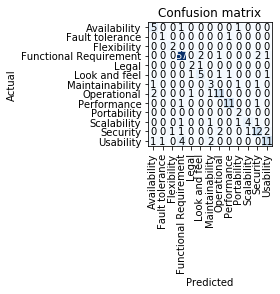

In [31]:
inter.plot_confusion_matrix()

In [32]:

classifier.predict("The product shall ensure that it can only be accessed by authorized users.  The product will be able to distinguish between authorized and unauthorized users in all access attempts")

(Category Security,
 tensor(11),
 tensor([2.7129e-07, 5.3954e-07, 5.0328e-06, 7.9993e-05, 1.2153e-06, 1.4472e-07,
         5.0268e-06, 6.3237e-06, 4.0261e-06, 3.7190e-07, 3.5457e-05, 9.9986e-01,
         1.1034e-06]))

In [33]:
#Usability
classifier.predict(" If projected  the data must be readable.  On a 10x10 projection screen  90% of viewers must be able to read Event / Activity data from a viewing distance of 30")

(Category Usability,
 tensor(12),
 tensor([5.7215e-05, 9.4512e-08, 5.2063e-07, 2.8075e-07, 1.1735e-05, 6.6916e-06,
         1.2874e-07, 1.0867e-07, 2.0803e-05, 3.1041e-06, 1.8224e-04, 1.8138e-06,
         9.9972e-01]))

In [34]:
#Functional requirement
classifier.predict("The system shall display Events or Activities.")

(Category Functional Requirement,
 tensor(3),
 tensor([6.3470e-05, 3.0911e-05, 1.8713e-04, 9.9674e-01, 5.3189e-05, 5.5559e-04,
         7.8536e-05, 7.7675e-04, 4.5212e-04, 2.3950e-04, 1.0724e-04, 3.6819e-04,
         3.4565e-04]))

In [35]:
# perfomance
classifier.predict("The response time of general student management tasks shall take no longer than 5 seconds and the response time of schedule generation shall take no longer than 30 seconds.")

(Category Performance,
 tensor(8),
 tensor([4.4182e-08, 1.1181e-08, 1.2023e-09, 6.8249e-11, 4.6326e-09, 1.2907e-08,
         3.7909e-07, 1.4463e-09, 1.0000e+00, 5.2454e-09, 6.2659e-10, 6.8128e-11,
         3.1979e-10]))

In [36]:
# functional requirement
classifier.predict(" The system shall be able to display a printable summary for individual cohorts  which will include the students enlisted  the Program of study  sequence of classes  cohort progress through the program  and timeline of completion.")

(Category Functional Requirement,
 tensor(3),
 tensor([5.2817e-06, 1.1045e-05, 9.0538e-05, 9.9957e-01, 3.6116e-05, 8.8311e-05,
         1.6860e-05, 1.4101e-05, 8.3518e-06, 3.7365e-05, 5.4458e-06, 1.1028e-05,
         1.0874e-04]))

In [37]:
#operational
classifier.predict("The Disputes application shall interface with the Cardmember Information Database.  The Cardmember Information Database provides detailed information with regard to a cardmember.  All cardmember detail information must be obtained from the Cardmember Information Database.")

(Category Operational,
 tensor(7),
 tensor([1.2415e-04, 8.5762e-05, 1.0971e-04, 2.9811e-04, 9.6246e-04, 2.7918e-03,
         3.5628e-05, 9.9172e-01, 2.4821e-04, 9.3780e-05, 1.5200e-05, 1.6026e-03,
         1.9165e-03]))

In [38]:

#security
classifier.predict('The Disputes System shall generate a User Report that details any new users that have been added and any changes to an existing user?s access level.  The report will be reviewed for auditing purposes.')

(Category Functional Requirement,
 tensor(3),
 tensor([3.6606e-05, 8.7847e-05, 1.6364e-04, 9.9336e-01, 6.6618e-05, 7.4030e-04,
         1.7811e-04, 3.6264e-04, 5.7800e-04, 3.9499e-05, 1.1978e-05, 2.7642e-03,
         1.6121e-03]))

In [39]:
#legal
classifier.predict("The Disputes application must conform to the legal requirements as specified by Regulation E and Regulation Z that govern credit card disputes processing.")

(Category Legal,
 tensor(4),
 tensor([8.1104e-05, 1.1760e-03, 2.0484e-04, 1.1905e-03, 9.7258e-01, 1.5289e-02,
         1.1830e-03, 7.0479e-03, 8.3791e-05, 9.1458e-05, 3.5256e-04, 8.8911e-05,
         6.3197e-04]))

In [40]:
#maintainability
classifier.predict("The product must be designed using Design Patterns and coding best practices.  90% of maintenance software developers are able to integrate new functionality into the product with 2 working days.")

(Category Maintainability,
 tensor(6),
 tensor([2.6676e-05, 2.7584e-03, 1.0970e-04, 9.6922e-06, 2.1152e-04, 7.8561e-06,
         9.6285e-01, 3.3120e-02, 9.0811e-05, 2.1221e-04, 5.1804e-05, 3.8702e-04,
         1.6211e-04]))

In [41]:
#look and feel
classifier.predict(" The website should have an African feel  but should not alienate non-Africans.  The website should use animation on pages which are describing the services  to grab the users attention and encourage them to sign up.")

(Category Look and feel,
 tensor(5),
 tensor([3.1408e-04, 1.9956e-02, 6.0977e-04, 4.2048e-05, 2.9650e-03, 9.3536e-01,
         9.1616e-05, 2.0859e-02, 4.2675e-05, 4.1507e-03, 1.4151e-05, 5.2793e-03,
         1.0315e-02]))

In [42]:
#scalability
classifier.predict("The effort needed to administer the payroll system (as measured in hours per month of system administrators’ time)  shall not increase with an increase in the number of employees.")

(Category Scalability,
 tensor(10),
 tensor([5.3226e-06, 6.2391e-08, 2.8395e-05, 9.6788e-06, 1.2760e-06, 6.0944e-07,
         1.9265e-06, 3.9773e-08, 3.9029e-08, 1.6277e-05, 9.9994e-01, 1.3996e-07,
         2.6548e-07]))

In [43]:
#flexibility
classifier.predict("No piece of text that might be displayed to a user shall reside in program source code.  Every piece of text that a  user might see must be modifiable without changing source code.  That is, no user?visible text will be “hard?coded.” ")

(Category Security,
 tensor(11),
 tensor([9.6145e-04, 4.0467e-02, 3.9215e-01, 4.4637e-04, 2.9100e-03, 5.7684e-03,
         9.4720e-03, 4.1855e-05, 4.8196e-04, 7.3884e-02, 1.3859e-04, 4.4769e-01,
         2.5587e-02]))